## Análisis

En este notebook vamos a hacer un análisis de las distintas competiciones (las cinco grandes ligas durante la temporada 2015-2016) y de todos los partidos en general para poder entender que características son más importantes a la hora de tomar la decisión por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

In [1]:
import shap
import pandas as pd
import numpy as np

### La Liga temporada 2015/2016 (masculina)

Cargamos los datos de los partidos sobre La Liga en la temporada 2015/2016 masculina para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [2]:
import os


competition_name = "La Liga"
competition_gender = "male"
season_name_for_filename = "2015_2016"

output_dir = "data/reduced/"
filename = f"{competition_name}({season_name_for_filename}_{competition_gender})_reduced.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_LaLiga = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/La Liga(2015_2016_male)_reduced.csv


In [3]:
matches_in_LaLiga.head(5)

,shots_on_target_ratio_home,shots_on_target_ratio_away,average_shots_on_target_distance_home,average_shots_on_target_distance_away,shots_inside_area_ratio_home,shots_inside_area_ratio_away,pass_success_ratio_home,pass_success_ratio_away,cross_success_ratio_home,cross_success_ratio_away,...,percentage_shots_under_pressure_home,percentage_shots_inside_area_under_pressure_home,percentage_passes_under_pressure_home,percentage_passes_inside_area_under_pressure_home,percentage_set_piece_shots_home,percentage_set_piece_shots_inside_area_home,percentage_substitutions_home,percentage_tactical_substitutions_home,percentage_tactical_changes_home,percentage_formation_changes_home
0,0.400000,0.153846,20.462904,15.923442,0.600000,0.384615,0.630915,0.804089,0.000000,0.000000,...,0.500000,1.000000,0.364780,0.000000,0.214286,0.285714,0.5,0.40,1.000000,0.5
1,0.312500,0.300000,25.239973,18.652679,0.187500,0.600000,0.759191,0.690647,0.285714,0.263158,...,0.666667,0.000000,0.476190,0.333333,0.470588,0.000000,0.5,0.50,1.000000,1.0
2,0.333333,0.400000,33.431447,11.773407,0.500000,0.700000,0.609065,0.809783,0.125000,0.222222,...,0.166667,0.250000,0.196491,0.400000,0.333333,0.250000,0.5,0.75,0.666667,0.5
3,0.461538,0.400000,24.394269,9.439840,0.538462,0.800000,0.760377,0.676543,0.125000,0.285714,...,0.500000,0.666667,0.582857,1.000000,0.600000,0.444444,0.5,0.60,0.500000,0.5
4,0.153846,0.200000,20.432657,19.849825,0.384615,0.800000,0.775176,0.700581,0.416667,0.272727,...,0.500000,0.000000,0.555556,0.750000,0.615385,0.384615,0.5,0.50,0.600000,0.5


Una vez ya tenemos los datos cargados, entrenamos el mejor modelo y mostramos sus resultados.

In [4]:
from src.analysis import laliga_best_model


best_model_LaLiga, evaluation_metrics, X_train_reduced_LaLiga, X_test_reduced_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga = laliga_best_model(matches_in_LaLiga)
print(f"The best model for La Liga is {best_model_LaLiga}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for La Liga is LogisticRegression(C=0.29354310869235306, max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
The evaluation metrics for the best model are:


,Train Accuracy,Test Accuracy,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,F1 Macro,F1 Weighted
Logistic Regression MI,0.766447,0.723684,0.702033,0.717442,0.684041,0.723684,0.690678,0.718346


Una vez ya tenemos el mejor modelo entrenado comenzamos el análisis de explicabilidad. Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Logistic Regression, vamos a fijarnos en el coeficiente (método coef_) que nos aporta el modelo para cada característica en cada clase. 
- Con esto, estamos observando la importancia global de cada característica para cada clase en términos de una relación lineal. Es decir, estamos observando relaciones exclusivamente lineales entre las características y la predicción.
- Con esto, no se tiene en cuenta las interacciones entre características ni tampoco explica predicciones individuales.

Los gráficos que se aparecen a continuación muestran la importancia de cada característica para predecir una determinada clase de resultado en los partidos de LaLiga. Las clases son:
- Clase "away_team": Indica qué características influyen en que el equipo visitante gane el partido.
- Clase "draw": Indica qué características influyen en que el partido termine en empate.
- Clase "home_team": Indica qué características influyen en que el equipo local gane el partido.

Los valores representados en el eje X son los coeficientes de la regresión logística, que indican la magnitud e impacto de cada variable en la probabilidad de un resultado específico. Valores positivos aumentan la probabilidad de que ocurra esa clase, mientras que valores negativos disminuyen dicha probabilidad.

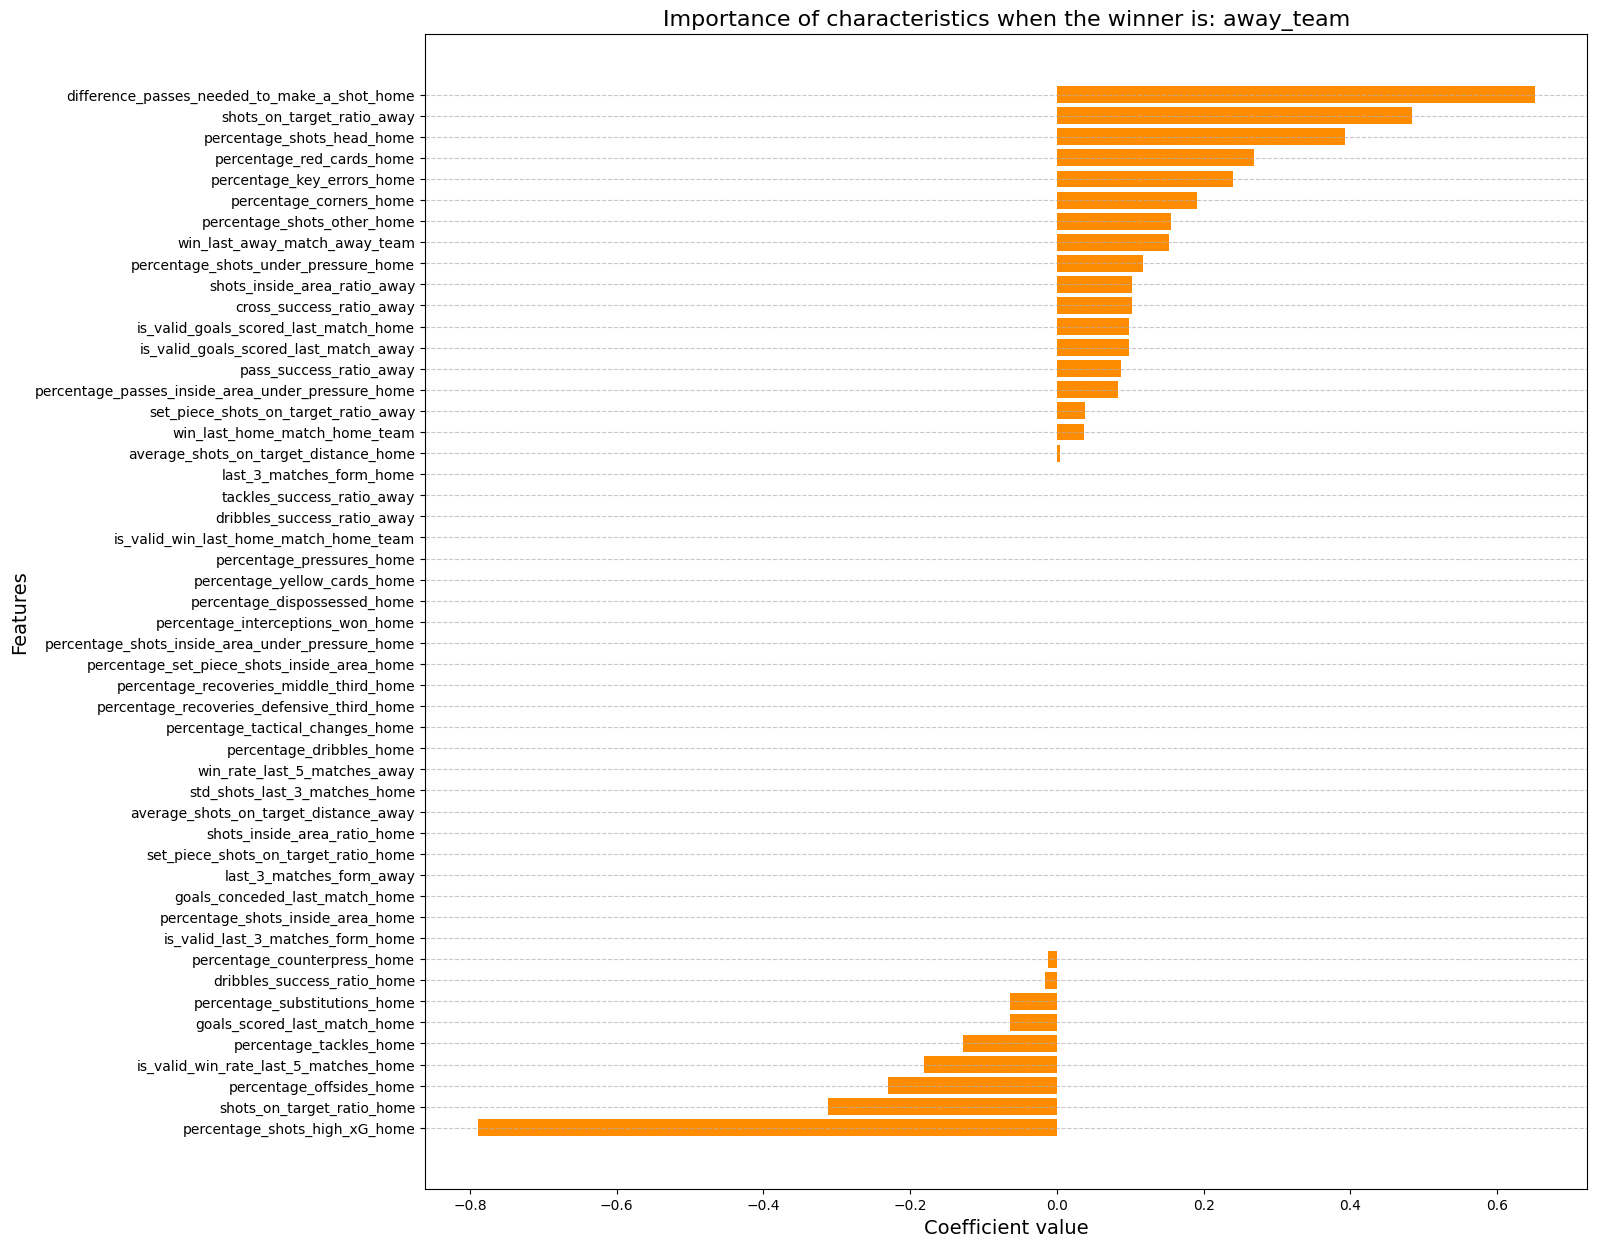

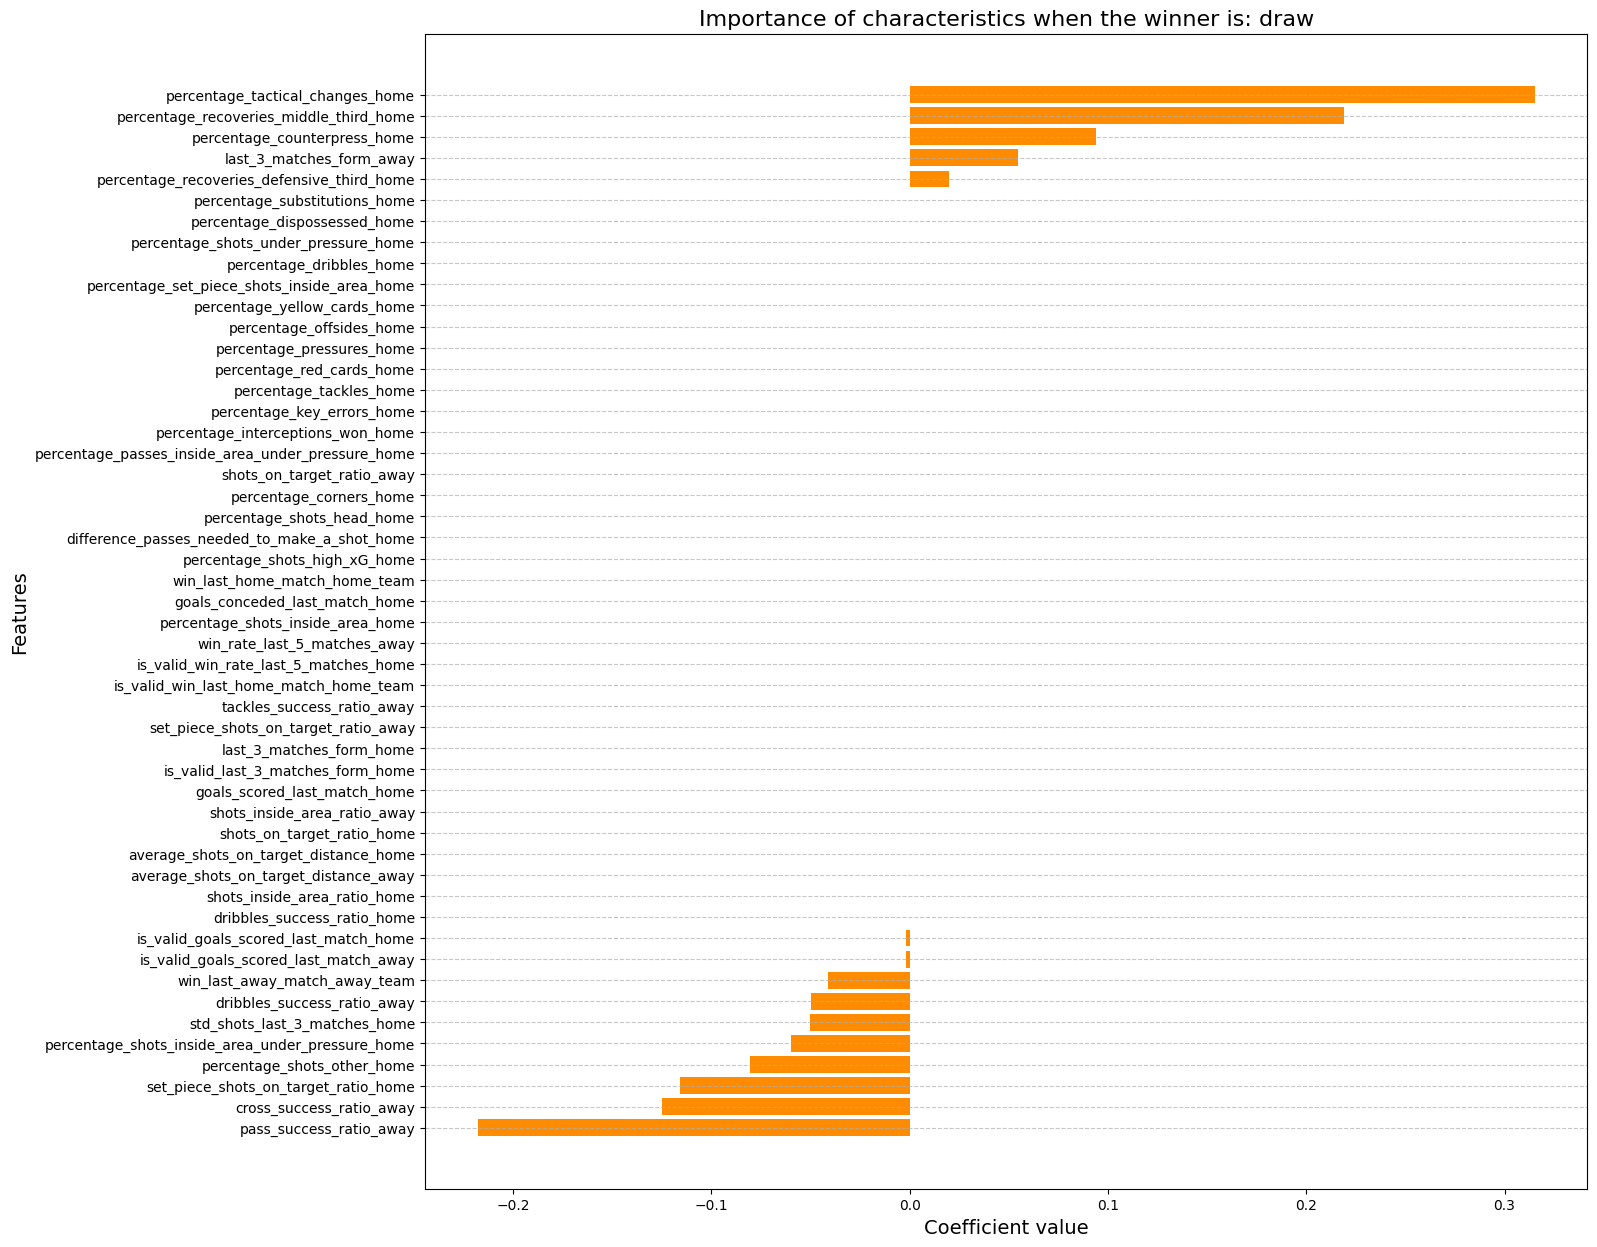

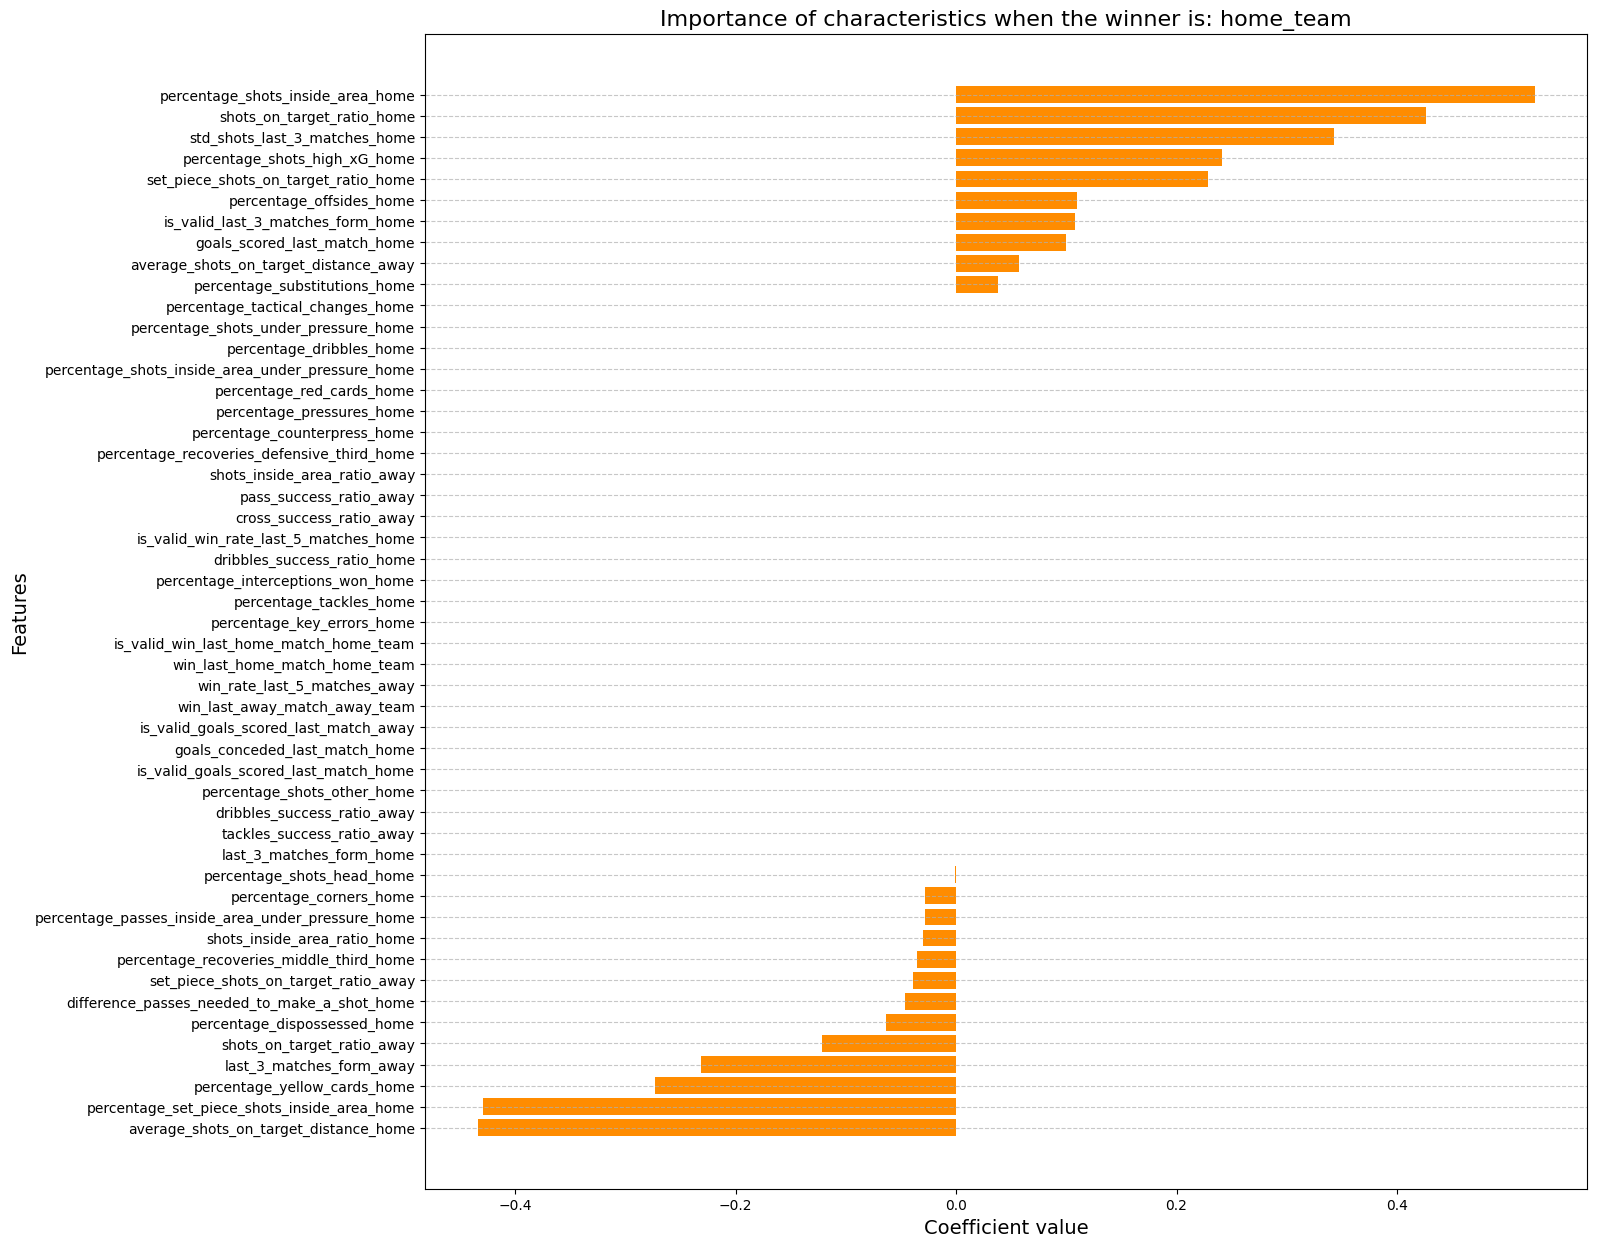

In [5]:
from src.analysis import laliga_global_analysis

laliga_global_analysis(best_model_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga)

Vamos a analizar cada uno de estos gráficos:

- **Importancia de características para la victoria del equipo visitante (*away_team*)**: Las características en este gráfico aumentan la probabilidad de que el equipo visitante gane el partido.
    - **Características que favorecen la victoria del equipo visitante**: 📈
        - `difference_passes_needed_to_make_a_shot_home`: Si el equipo local necesita más pases para generar un tiro, su ataque es menos eficiente, lo que favorece al visitante.
        - `shots_on_target_ratio_away`: Un equipo visitante con un alto porcentaje de tiros a puerta tiene más probabilidades de marcar y ganar.
        - `percentage_shots_head_home`: Al aumentar estos porcentajes puede significar que el equipo local no esta encontrando otro recurso que no sea el juego aéreo para atacar al equipo visitante debido a que consiguen defender bien.
        - `percentage_red_cards_home`: Si aumenta significa que el equipo local ha perdido algún jugador lo cual hace que este en inferioridad y que tengan que cambiar los planes lo cual favorece al equipo visitante.
        - `percentage_key_errors_home`: Más errores clave del equipo local que el equipo visitante que pueden ser aprovechados por el visitante.
        - `percentage_corners_home`: El equipo local esta fallando más lo cual esta derivando en que las jugadas acaben en más corners que en goles.
        - `win_last_away_match_away_team`: También influye que el equipo visitante ganase su último partido como visitante ya que esto puede indicar una dinámica positiva.
        - `percentage_shots_under_pressure_home`: Entre más tiros haya hecho con presión el equipo local que el visitante, más probabilidades tendrá de no meter gol el equipo local.
        - `shots_inside_area_ratio_away`: Entre mayor sea el ratio de tiros dentro del área del equipo visitante respecto a sus tiros en el partido, mayor probabilidad tiene de marcar gol ya que el tiro será más peligroso.
        - `cross_sucess_ratio_away`, `passes_success_ratio_away`: Entre mayor sean estos ratios, mayor acierto se ha tenido en la circulación del balón por el equipo visitante lo cual le favorece.
        - `percentage_passes_inside_area_under_pressure_home`: Entre mayor sea el porcentaje, significa que el equipo visitante presiona más los pases en el área que el equipo local lo cual influye en que no puedan jugar de manera cómoda cerca de la portería rival y tengan menos facilidad de meter gol los rivales (locales).
    - **Características que no favorecen la victoria del equipo visitante**: 📉
        - `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`: Si el equipo local tiene muchos tiros con un alto porcentaje de gol o un alto porcentaje de tiros a puerta, genera más peligro, por lo que esta característica tiene un coeficiente negativo en la victoria del visitante.
        - `percentage_offsides_home`: Si el equipo local ha caido más veces en fuera de juego puede significar que están atacando más lo que puede implicar que mantengan más tiempo la pelota y que estén constantemente buscando la espalda del equipo visitante.
        - `percentage_tackles_home`: significa que el equipo local hace más tackles que el equipo visitante lo cual puede influir negativamente sobre el equipo visitante ya que puede llevar a más recuperaciones por parte del equipo local o puede llevar a que cortan jugadas prometedoras del equipo visitante.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar una gran cantidad de goles esto puede influir en que el equipo local vengan motivados y en un buen estado de forma lo cual influye negativamente en el equipo visitante.
        - `dribbles_sucess_ratio_home`: Entre mayor sea el ratio de regates completados por el equipo local, mayor capacidad para superar a jugadores del equipo visitante han tenido lo cual puede implicar situaciones peligrosas en el juego a favor del equipo visitante.
    - **Características que no tienen importancia en la victoria del equipo visitante**:
        - `last_3_matches_form_home`, `last_3_matches_form_away`: Parece ser que la forma de los últimos partidos de los dos equipos no influye en una posible victoria del equipo visitante.
        - `percentage_yellow_cards_home`: El porcentaje de tarjetas amarillas del equipo local respecto al total del partido no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_home`: La cantidad de tiros dentro del área del equipo local respecto al total del partido (local+visitante) no influye en la victoria del equipo visitante.
        - `percentage_recoveries_defensive_third_home`, `percentage_recoveries_middle_third_home`: La cantidad de recuperaciones del equipo local en el cualquier tercio del campo respecto al total del partido no influye en la victoria del equipo visitante.
        - `average_shots_on_target_distance_away`: La distancia media de donde se hagan los tiros a puerta del equipo visitante no influye en la victoria del equipo visitante.
        - `percentage_pressures_home`: La cantidad de presiones del equipo local respecto al total no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_under_pressure_home`, `percentage_dribbles_home`... son algunas de las demás características que no influyen en la victoria del equipo visitante.
    **Conclusión**: Para que un equipo visitante tenga una mayor probabilidad de ganar, necesita ser eficiente en ataque, aprovechar los errores y dificultades del equipo local, y contar con una dinámica positiva previa en partidos fuera de casa. Sin embargo, si el equipo local logra generar peligro con tiros de calidad, una defensa sólida y un juego ofensivo activo, la victoria del visitante se vuelve menos probable. Algunos factores que no son infuyentes son: la dinámica general que se lleve en varios partidos atrás (sin embargo, partidos justo anteriores sí), recuperaciones en cualquier tercio del campo, tarjetas amarillas...

- **Importancia de características para el empate (*draw*)**: El empate en un partido suele estar influenciado por un equilibrio en las métricas de ataque y defensa de ambos equipos. Algunas observaciones clave:
    - **Características que favorecen el empate**: 📈
        - `percentage_tactical_changes_home`: Si el equipo local realiza más cambios tácticos durante el partido puede estar ajustando su estrategia constantemente, lo que puede evitar que el equipo visitante imponga su dominio y llevar el partido a un empate.
        - `percentage_recoveries_middle_third_home`: Un alto porcentaje de recuperaciones en el tercio medio por el equipo local indica un partido trabado en el centro del campo, con dificultades para que alguno de los equipos genere oportunidades claras.
        - `percentage_counterpress_home`: Una alta presión tras pérdida por parte del equipo local impide que el equipo rival lance ataques rápidos, manteniendo el juego más equilibrado.
        - `last_3_matches_form_away`: Si el equipo visitante ha tenido un buen rendimiento en los últimos tres partidos, puede ser menos propenso a perder a pesar de jugar fuera, aumentando la probabilidad de un empate.
        - `percentage_recoveries_defensive_third_home`: Si el equipo local recupera muchos balones en su tercio defensivo, evita que el equipo visitante genere muchas ocasiones de gol, lo que favorece un partido con pocos goles y, por ende, un empate.
    - **Características que no favorecen el empate**: 📉
        - `cross_success_ratio_away`, `pass_success_ratio_away`: Si el equipo visitante tiene un alto porcentaje de acierto en pases y centros, es más probable que genere situaciones de peligro y pueda romper el empate con un gol.
        - `set_piece_shots_on_target_ratio_home`: Un equipo local que tiene un alto porcentaje de tiros a puerta desde jugadas a balón parado puede aprovechar estas situaciones para ganar el partido.
        - `dribbles_success_ratio_away`: Si el equipo visitante tiene un alto ratio de regates significa que en varios momneto ha podido estar en superioridad y de esta manera tener más ocasiones para ganar el partido.
        - `win_last_away_match_away_team`: Si el equipo visitante ha ganado su último partido fuera de casa puede significar que viene en una buena dinámica fuera de casa y que puede ganar el partido y romper el empate.
        - `std_shots_last_3_matches_home`: Significa que el equipo local mantiene un número de tiros bastante constante en los partidos lo que puede signficar que si está en una mala dinámica tira muy poco y puede perder el partido o si está en una buena dinámica tira mucho y puede ganar el partido rompiendo así el empate.
    - **Características que no tienen importancia en el empate**:
        - `win_rate_last_5_matches_away`: La tasa de victorias del equipo visitante en los últimos cinco partidos no parece ser un factor determinante para el empate.
        - `percentage_tackles_home`: La cantidad de entradas realizadas por los equipos no tiene una relación clara con la probabilidad de empate.
        - `percentage_interceptions_won_home`: A pesar de ser una métrica defensiva importante, no tiene un impacto significativo en el resultado final del partido.
        - `percentage_shots_inside_area_under_pressure_home`: A pesar de indicar situaciones de presión en el área, no parece afectar la probabilidad de empate.
        - `difference_passes_needed_to_make_a_shot_home`, `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`, `goals_scored_last_match_home`, `goals_conceded_last_match_home`, `percentage_red_cards_home`, `percentage_yellow_cards_home`... son algunas de las métrica que no tienen importancia a la hora de predecir un empate.
    - **Conclusión**: Un empate suele ser el resultado de un partido equilibrado donde ninguno de los equipos logra imponerse claramente. Factores como la gestión táctica, las recuperaciones en el medio campo, la solidez defensiva y la estabilidad en el rendimiento reciente pueden favorecer un empate. Por otro lado, si uno de los equipos demuestra una alta efectividad en ataque, mayor precisión en pases y centros, o un dominio en jugadas a balón parado, la probabilidad de empate disminuye. Finalmente, ciertos aspectos como el rendimiento en partidos anteriores o métricas defensivas específicas no parecen influir directamente en la probabilidad de que el partido termine en empate.

- **Importancia de características para la victoria del equipo local (*home_team*)**: Las características en este gráfico aumentan la probabilidad de que el equipo visitante gane el partido.
    - **Características que favorecen la victoria del equipo local**: 📈
        - `percentage_shots_inside_area_home`: Un mayor porcentaje de tiros dentro del área indica que el equipo local está generando oportunidades claras de gol.
        - `shots_on_target_ratio_home`: Un equipo local con un alto porcentaje de tiros a puerta tiene más probabilidades de marcar goles.
        - `std_shots_last_3_matches_home`: Una menor variabilidad en los tiros en los últimos tres partidos puede indicar que el equipo local mantiene una producción ofensiva constante.
        - `percentage_shots_high_xG_home`: Un equipo local que logra disparos con un alto xG (expectativa de gol) genera más ocasiones peligrosas.
        - set_piece_shots_on_target_ratio_home: Indica que el equipo local aprovecha mejor sus oportunidades a balón parado.
    - **Características que no favorecen la victoria del equipo local**: 📉
        - `percentage_shots_high_xG_home`, `shots_on_target_ratio_home`: Si el equipo local tiene muchos tiros con un alto porcentaje de gol o un alto porcentaje de tiros a puerta, genera más peligro, por lo que esta característica tiene un coeficiente negativo en la victoria del visitante.
        - `percentage_offsides_home`: Si el equipo local ha caido más veces en fuera de juego puede significar que están atacando más lo que puede implicar que mantengan más tiempo la pelota y que estén constantemente buscando la espalda del equipo visitante.
        - `percentage_tackles_home`: significa que el equipo local hace más tackles que el equipo visitante lo cual puede influir negativamente sobre el equipo visitante ya que puede llevar a más recuperaciones por parte del equipo local o puede llevar a que cortan jugadas prometedoras del equipo visitante.
        - `goals_scored_last_match_home`: Si el equipo local viene de marcar una gran cantidad de goles esto puede influir en que el equipo local vengan motivados y en un buen estado de forma lo cual influye negativamente en el equipo visitante.
        - `dribbles_sucess_ratio_home`: Entre mayor sea el ratio de regates completados por el equipo local, mayor capacidad para superar a jugadores del equipo visitante han tenido lo cual puede implicar situaciones peligrosas en el juego a favor del equipo visitante.
    - **Características que no tienen importancia en la victoria del equipo local**:
        - `last_3_matches_form_home`, `last_3_matches_form_away`: Parece ser que la forma de los últimos partidos de los dos equipos no influye en una posible victoria del equipo visitante.
        - `percentage_yellow_cards_home`: El porcentaje de tarjetas amarillas del equipo local respecto al total del partido no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_home`: La cantidad de tiros dentro del área del equipo local respecto al total del partido (local+visitante) no influye en la victoria del equipo visitante.
        - `percentage_recoveries_defensive_third_home`, `percentage_recoveries_middle_third_home`: La cantidad de recuperaciones del equipo local en el cualquier tercio del campo respecto al total del partido no influye en la victoria del equipo visitante.
        - `average_shots_on_target_distance_away`: La distancia media de donde se hagan los tiros a puerta del equipo visitante no influye en la victoria del equipo visitante.
        - `percentage_pressures_home`: La cantidad de presiones del equipo local respecto al total no influye en la victoria del equipo visitante.
        - `percentage_shots_inside_area_under_pressure_home`, `percentage_dribbles_home`... son algunas de las demás características que no influyen en la victoria del equipo visitante.
    **Conclusión**: Para que un equipo visitante tenga una mayor probabilidad de ganar, necesita ser eficiente en ataque, aprovechar los errores y dificultades del equipo local, y contar con una dinámica positiva previa en partidos fuera de casa. Sin embargo, si el equipo local logra generar peligro con tiros de calidad, una defensa sólida y un juego ofensivo activo, la victoria del visitante se vuelve menos probable. Algunos factores que no son infuyentes son: la dinámica general que se lleve en varios partidos atrás (sin embargo, partidos justo anteriores sí), recuperaciones en cualquier tercio del campo, tarjetas amarillas...

- **Conclusiones generales**: 
    - El equipo visitante gana cuando tiene alta precisión en sus tiros a puerta y el equipo local es ineficiente ofensivamente.
    - El empate ocurre en partidos con alta presión en el mediocampo y cambios tácticos, lo que equilibra el juego.
    - El equipo local gana cuando genera muchas oportunidades de gol dentro del área y tiene buena precisión en sus tiros.

Ahora comenzamos el análisis de explicabilidad utilizando SHAP.

In [6]:
explainer_LaLiga = shap.Explainer(best_model_LaLiga, X_train_reduced_LaLiga, feature_names=feature_names_reduced_LaLiga)
shap_values_LaLiga = explainer_LaLiga(X_test_reduced_LaLiga)

Clase 0: ['away_team']
Características importantes (27):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_home_match_home_team', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'percentage_shots_high_xG_home', 'percentage_shots_head_home', 'percentage_shots_other_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_red_cards_home', 'percentage_counterpress_home', 'percentage_offsides_home', 'percentage_shots_under_pressure_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_substitutions_home']
Características SIN i

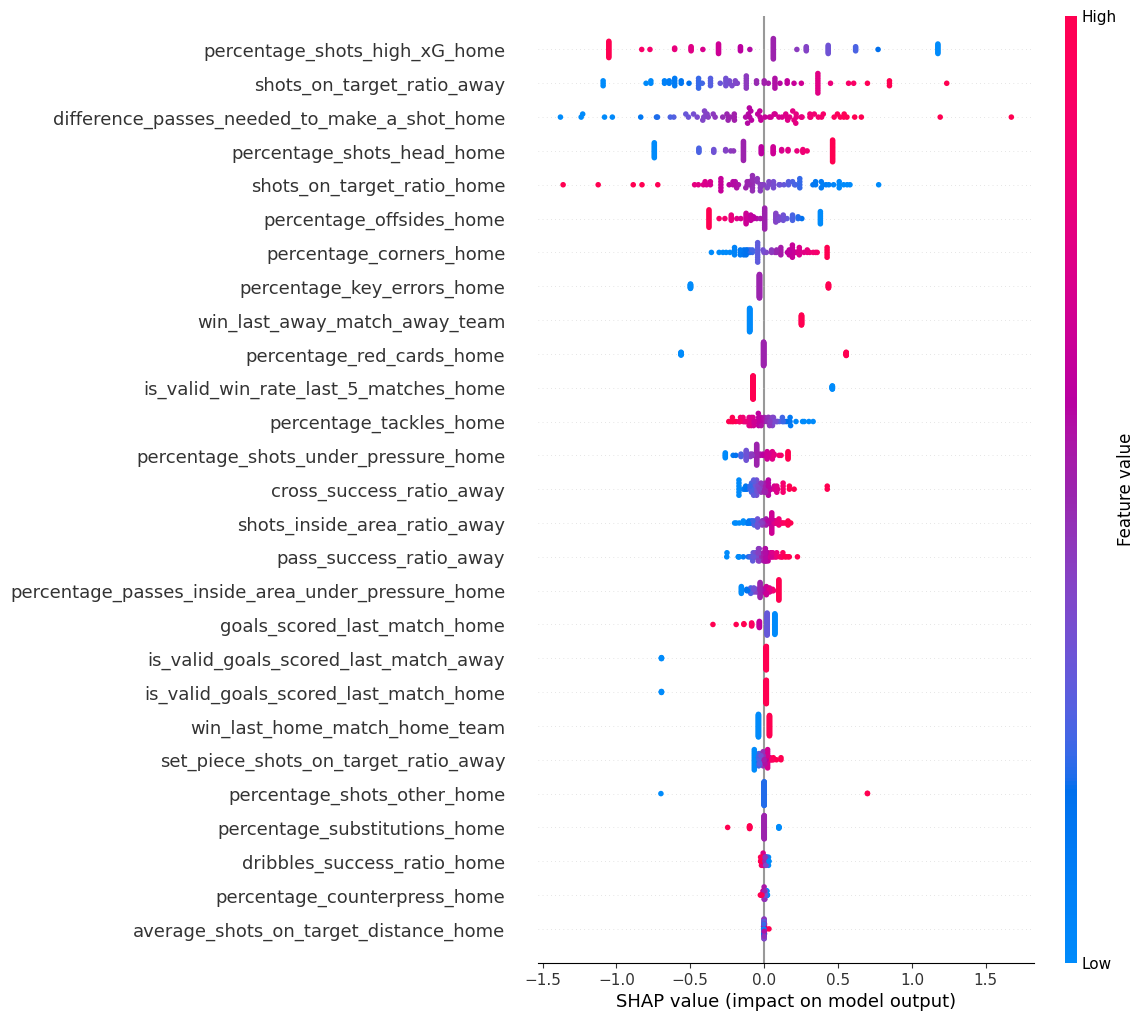

Clase 1: ['draw']
Características importantes (15):
['pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'last_3_matches_form_away', 'win_last_away_match_away_team', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'std_shots_last_3_matches_home', 'percentage_shots_other_home', 'percentage_counterpress_home', 'percentage_recoveries_middle_third_home', 'percentage_recoveries_defensive_third_home', 'percentage_shots_inside_area_under_pressure_home', 'percentage_tactical_changes_home']
Características SIN impacto (35):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'tackles_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_home', 'is_valid_last_3_matches_form_home'

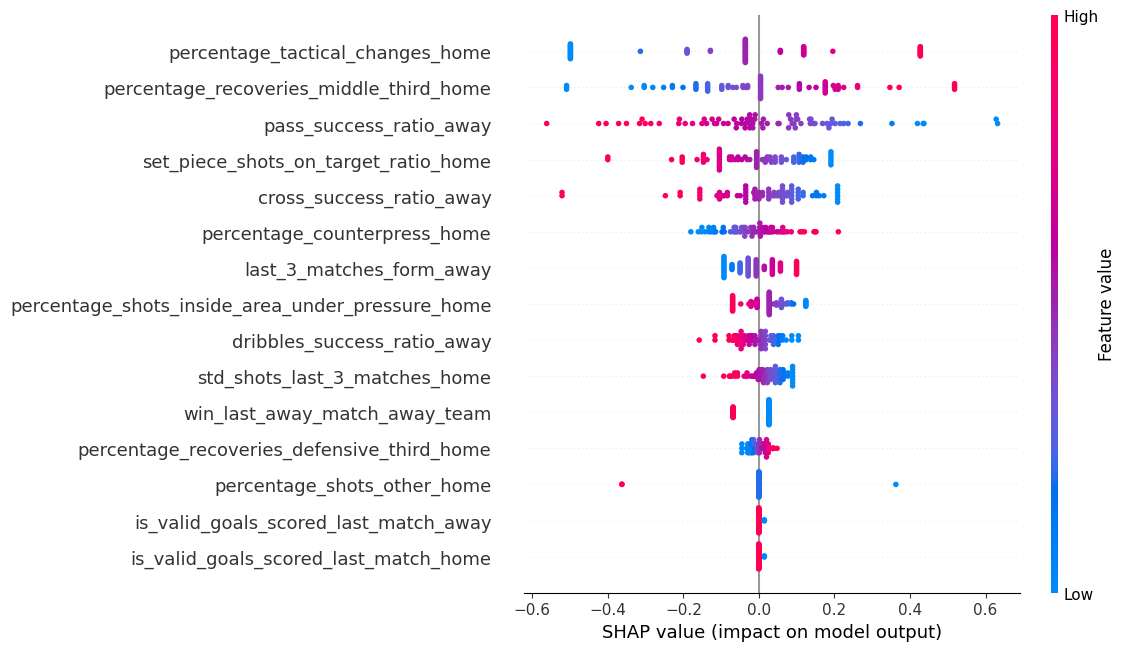

Clase 2: ['home_team']
Características importantes (23):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_last_3_matches_form_home', 'last_3_matches_form_away', 'goals_scored_last_match_home', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_head_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_yellow_cards_home', 'percentage_offsides_home', 'percentage_dispossessed_home', 'percentage_recoveries_middle_third_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_set_piece_shots_inside_area_home', 'percentage_substitutions_home']
Características SIN impacto (27):
['shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_

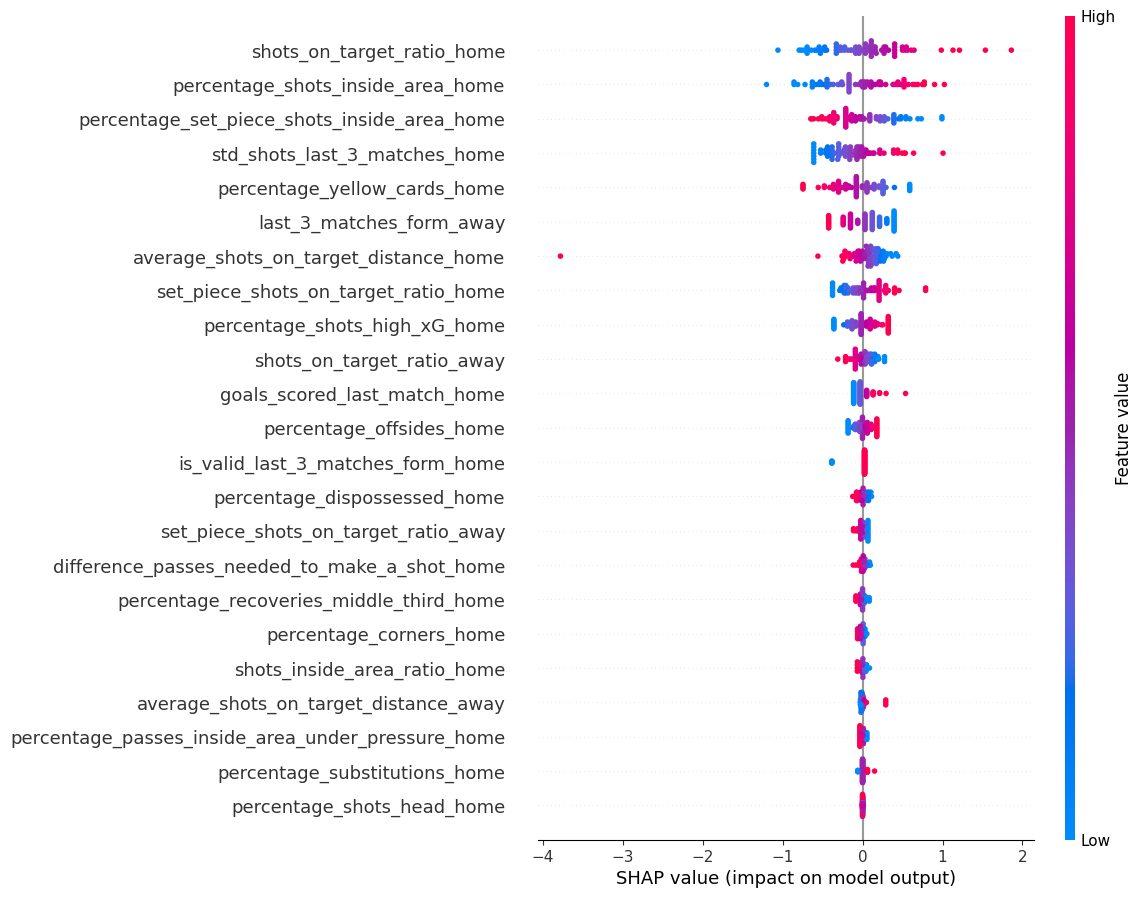

In [7]:
# definimos un umbral de importancia
threshold = 0.0

for i in range(shap_values_LaLiga.shape[2]):
    print(f"Clase {i}: {encoder_LaLiga.inverse_transform([i])}")
    # calculamos la importancia media de cada característica y filtramos las características que superen el umbral
    shap_importance = np.abs(shap_values_LaLiga.values[:, :, i]).mean(axis=0)
    important_features = np.where(shap_importance > threshold)[0]
    unimportant_features = np.where(shap_importance <= threshold)[0]
    print(f"Características importantes ({len(important_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in important_features])
    print(f"Características SIN impacto ({len(unimportant_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in unimportant_features])
    # si hay características que superen el umbral, mostramos el gráfico
    if len(important_features) > 0:
        shap.plots.beeswarm(shap_values_LaLiga[:, important_features, i], max_display=important_features.size)
    else:
        print(f"No hay características con impacto mayor a {threshold} para la clase {i}.")